In [ ]:
'''# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session'''

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl

import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"  #make sure all data are stored in the right device 

# Load Data

In [3]:
class LazyLoadDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        self.transform = transform
        path = path + ("train/" if train else "test/")  #data and target path
        self.pathX = path + "X/"
        self.pathY = path + "Y/"
        self.data = os.listdir(self.pathX)
        
    def __getitem__(self, idx):
        f = self.data[idx] 
        
        #X
        #read rgb images
        img0 = cv2.imread(self.pathX + f + "/rgb/0.png")  
        img1 = cv2.imread(self.pathX + f + "/rgb/1.png")
        img2 = cv2.imread(self.pathX + f + "/rgb/2.png")
        
        #read depth images
        depth = np.load(self.pathX + f + "/depth.npy")
        
        #normalize image
        img0=cv2.normalize(img0, None, 0, 1, cv2.NORM_MINMAX)
        img1=cv2.normalize(img1, None, 0, 1, cv2.NORM_MINMAX)
        img2=cv2.normalize(img2, None, 0, 1, cv2.NORM_MINMAX)
        depth=cv2.normalize(depth/1000, 0, 1, cv2.NORM_MINMAX)
        
        #transform
        if self.transform is not None:   
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            #depth = self.transform(depth)
            #print("transformed")  
            
        #read field ID
        field_id = pkl.load(open(self.pathX+f+"/field_id.pkl", "rb"))
        
        #Y
        Y = np.load(self.pathY+f+".npy")

        return (img0, img1, img2, depth, field_id), Y
    
    def __len__(self):
        return len(self.data)


In [4]:
transform=transforms.Compose([transforms.ToTensor()])
dataset= LazyLoadDataset("/kaggle/input/lazydata/lazydata/", transform = transform)


In [5]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)


In [6]:
(img0, img1, img2, depth, field_id), Y = dataset[0]  

In [7]:
len(dataset[1][0])

5

In [8]:
field_id

'488'

In [9]:
Y.shape

(12,)

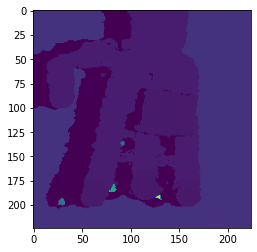

In [10]:
import matplotlib.pyplot as plt
#plt.imshow(img0[:,:,::-1])
plt.imshow(depth[0])
plt.show()

In [11]:
# function to count number of parameters
def get_n_params(model):
    # return number of parameters in model
    numParam = model.parameters()
    count = 0
    #print(numParam)
    #print(list(numParam))
    for i in list(numParam):
        j = 1
        for k in i.size():
            j = j * k
        count = count + j
    return count

# Train Data and Build Model

In [12]:
def train(epoch, model, optimizer, permute_pixels=None, permutation_order=None):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        
        #print(len(data[0][0][0])) #5, 64, 3, 224, 224
        
        #stack data
        angleStack = torch.stack((data[0][:,0,:,:], data[0][:,1,:,:], data[0][:,2,:,:],
                                  data[1][:,0,:,:], data[1][:,1,:,:], data[1][:,2,:,:],
                                  data[2][:,0,:,:], data[2][:,1,:,:], data[2][:,2,:,:]),1)
        
        #print(data[3].shape, angleStack.shape)  #[64, 3, 224, 224], [64, 9, 224, 224]
        
        depthStack = torch.stack((data[3][:,0,:,:], data[3][:,1,:,:], data[3][:,2,:,:]),1)
        
        #print(angleStack.shape, depthStack.shape)
        
        data1=torch.cat((angleStack, depthStack), 1)  #[64, 9, 224, 224], [64, 3, 224, 224]
        
        #print(data1.shape)  #64, 12, 224, 224
        data = data1
        
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)      

        #backpropagation
        optimizer.zero_grad()  #make sure to erase all gradients before computing new ones
        output = model(data)
        loss_fn = nn.MSELoss()  
        loss = loss_fn(output.float(), target.float())  

        loss.backward()  #compute gradients of parameters wrt loss (chain rule)
        optimizer.step()  #update weights using gradients and learning rate
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))

In [13]:
class CNN(nn.Module):
    def __init__(self, input_size, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(input_size, conv_feature, kernel_size=5)  #12 224 224
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride = 4)  #256 220 220  (=224-5+1)
        self.conv2 = nn.Conv2d(conv_feature, conv_feature, kernel_size=3)  #256 72 72  (=(220-4)/3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)   #256 70 70
        self.conv3 = nn.Conv2d(conv_feature, conv_feature, kernel_size=3)  #256 35 35
        self.pool3 = nn.MaxPool2d(kernel_size=3)   #256 33 33
        self.conv4 = nn.Conv2d(conv_feature, conv_feature, kernel_size=4)  #256 11 11
        
        self.fc1 = nn.Linear(conv_feature*5*5, fc_feature)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc_feature, output_size)
        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.conv4(x)
        #x = torch.flatten(x, 1)
        x = x.view(-1, 256*5*5)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [14]:
# Training settings 
conv_features = 256 # number of feature maps
input_channels = 12 # number of input channels
fc_features = 50
output_size = 12

# create CNN model
model_cnn = CNN(input_channels, conv_features, fc_features, output_size) # create CNN model


model_cnn.to(device)
# use Adam with learning rate 0.001
optimizer = optim.Adam(params = model_cnn.parameters(), lr = 0.001)     
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.8)

print('Number of parameters: {}'.format(get_n_params(model_cnn)))

test_accuracy = []
for epoch in range(0, 10):
    train(epoch, model_cnn, optimizer)
    scheduler.step()

Number of parameters: 2626710
Train Epoch: 0 [0/3396 (0%)]	Loss: 0.009956
Train Epoch: 0 [1280/3396 (37%)]	Loss: 0.004820
Train Epoch: 0 [2560/3396 (74%)]	Loss: 0.002314
Train Epoch: 1 [0/3396 (0%)]	Loss: 0.002290
Train Epoch: 1 [1280/3396 (37%)]	Loss: 0.001737
Train Epoch: 1 [2560/3396 (74%)]	Loss: 0.001306
Train Epoch: 2 [0/3396 (0%)]	Loss: 0.001435
Train Epoch: 2 [1280/3396 (37%)]	Loss: 0.001022
Train Epoch: 2 [2560/3396 (74%)]	Loss: 0.001156
Train Epoch: 3 [0/3396 (0%)]	Loss: 0.000832
Train Epoch: 3 [1280/3396 (37%)]	Loss: 0.000911
Train Epoch: 3 [2560/3396 (74%)]	Loss: 0.000916
Train Epoch: 4 [0/3396 (0%)]	Loss: 0.000968
Train Epoch: 4 [1280/3396 (37%)]	Loss: 0.000859
Train Epoch: 4 [2560/3396 (74%)]	Loss: 0.000875
Train Epoch: 5 [0/3396 (0%)]	Loss: 0.000761
Train Epoch: 5 [1280/3396 (37%)]	Loss: 0.000730
Train Epoch: 5 [2560/3396 (74%)]	Loss: 0.000823
Train Epoch: 6 [0/3396 (0%)]	Loss: 0.000635
Train Epoch: 6 [1280/3396 (37%)]	Loss: 0.000747
Train Epoch: 6 [2560/3396 (74%)]	Loss:

# Save Model, Make Prediction using Test Data, Output CSV File

In [15]:
torch.save(model_cnn.state_dict(), "ML_Capstone.pt")

In [16]:
model = model_cnn
model.load_state_dict(torch.load('ML_Capstone.pt'))
model.eval()

CNN(
  (relu): ReLU()
  (conv1): Conv2d(12, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=50, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=12, bias=True)
)

In [17]:
import pickle
import pandas as pd

outfile = 'submission.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
preds = []

test_data = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/test/test/testX.pt')
file_ids = test_data[-1]
rgb_data = test_data[0]
########
newData = torch.cat((rgb_data[:,0],rgb_data[:,1],rgb_data[:,2], test_data[1]),dim=1)
#print(rgb_data.shape, newData.shape) 
model.eval()
split = torch.split(newData,50,dim=0)
#for i, data in enumerate(rgb_data):
print(split[0].shape)
for i, data in enumerate(split):
    
    output = model(data.to(device))
    preds.append(output.cpu().detach().numpy())
    #preds.append(output[0].cpu().detach().numpy())

df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(np.concatenate(preds)/1000)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

torch.Size([50, 12, 224, 224])
Written to csv file submission.csv
